# Optimize the model

From the regularization notebook it can be seen that while convolutional layer increases accuracy of training, the model becomes overfit too fast.

The goal of this part of the project is to minimize divergence between validation and training loss while maintaining positive accuracy gradient. Thus, we want accuracy of training & validation to be as close to 1 as possible with validation and training loss being as close to 0 as possible.

To do that, we will use feature-reducing techniques and Data Augmentation.

To reduce features we inroduce Pooling layer after the convolutional layer. Also, instead of using one Conv2D layer with large amount of filters we introduce a sequence of Conv2D layers with smaller amount of filters (also followed by MaxPooling2D)

In [ ]:
# %pip install tensorflow-gpu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

For data albumentations we can use in-built keras methods, but can also try something different

In [ ]:
import albumentations as alb

## Load and pre-process the data

In [ ]:
train_ds, test_ds = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
val_ds = (train_ds[0][40000:], train_ds[1][40000:])


train_ds = (train_ds[0][:40000], train_ds[1][:40000])


In [ ]:
print(train_ds[0].shape)
print(val_ds[0].shape)
print(test_ds[0].shape)

print(train_ds[1].shape)
print(val_ds[1].shape)
print(test_ds[1].shape)

(40000, 28, 28)
(20000, 28, 28)
(10000, 28, 28)
(40000,)
(20000,)
(10000,)


In [ ]:
train_img = train_ds[0]/255
val_img = val_ds[0]/255
test_img = test_ds[0]/255

train_lbl = train_ds[1]
val_lbl = val_ds[1]
test_lbl = test_ds[1]

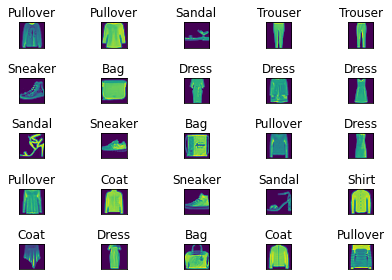

In [ ]:
idx = []
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(25):
    idx.append(np.random.randint(1,len(train_img)))

idx = np.asarray(idx)

fig = plt.figure()

for i in range(len(idx)):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(train_img[idx[i]])
    ax.title.set_text(class_names[train_lbl[idx[i]]])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Define the augmentation pipeline

In [ ]:
transform = alb.Compose([
    alb.HorizontalFlip(p=0.4),
    alb.VerticalFlip(p=0.4),
    alb.Rotate(p=0.4)
    ,alb.Blur(p=0.2, blur_limit=5)
])

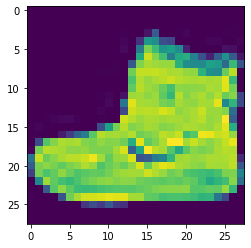

In [ ]:
test = train_img[0]
plt.imshow(test)


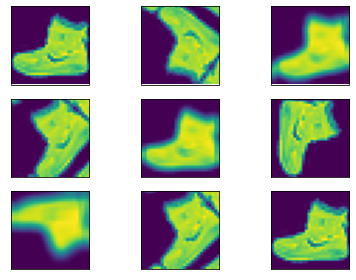

In [ ]:
fig = plt.figure()

for i in range(9):

    aug_tst = transform(image=test)["image"]

    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(aug_tst)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Now we need to apply the augmentation pipeline to the dataset

In [ ]:
# assign datasets to new variables so that the initial are not damaged in case of my miserable failure (backup point)

dummy_train_ds = train_ds
dummy_val_ds = val_ds
dummy_test_ds = test_ds

In [ ]:
# number of augmentations applied to each picture

n_aug = 18

In [ ]:
len(train_ds[0])

40000

In [ ]:
train_images = [image for image in dummy_train_ds[0]]
train_labels = [label for label in dummy_train_ds[1]]

In [ ]:
np.array(train_images).shape

(40000, 28, 28)

In [ ]:

for img in range(len(train_ds[0])):

    for i in range(n_aug):

        aug_image = transform(image=train_ds[0][img])["image"]
        train_images.append(aug_image)
        train_labels.append(train_ds[1][img])



In [ ]:
shuffle_idx = np.random.permutation(len(train_images))
images_train_augmented = np.array(train_images)[shuffle_idx]
labels_train_augmented = np.array(train_labels)[shuffle_idx]

In [ ]:
images_train_augmented.shape

(760000, 28, 28)

In [ ]:
labels_train_augmented.shape

(760000,)

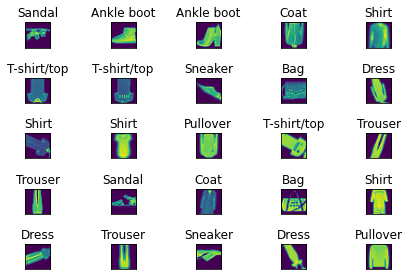

In [ ]:
idx = []
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(25):
    idx.append(np.random.randint(1,len(images_train_augmented)))

idx = np.asarray(idx)

fig = plt.figure()

for i in range(len(idx)):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(images_train_augmented[idx[i]])
    ax.title.set_text(class_names[labels_train_augmented[idx[i]]])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
print((train_ds[0].shape))
print(images_train_augmented.shape)
print(val_img.shape)

(40000, 28, 28)
(760000, 28, 28)
(20000, 28, 28)


Can now use augmented data for training of the model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [ ]:
initial_learning_rate = 0.0001

opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
a = int(len(images_train_augmented)-(0.2*len(images_train_augmented)))
a

608000

In [ ]:
val_img_aug, val_lbl_aug = images_train_augmented[a:], labels_train_augmented[a:]

images_train_augmented, labels_train_augmented = images_train_augmented[:a], labels_train_augmented[:a]

In [ ]:
print(images_train_augmented.shape)
print(val_img_aug.shape)

(320000, 28, 28)
(80000, 28, 28)


### Define a new model

We were using quite some feature reducing layers with only one interpretation layer. In practice, one convolutional layer with pooling might be enough and it is better to introduce more fully connected layers instead

We can also add a BatchNormalisation layer before activation functions in attempt to improve accuracy a bit more

In [ ]:
from keras.layers import BatchNormalization, Activation

In [ ]:
model_cnn_v2 = tf.keras.models.Sequential()

In [ ]:
# dropout regularisation layer
model_cnn_v2.add(Dropout(rate=0.3, input_shape=(28, 28, 1)))

# feature extraction layers


model_cnn_v2.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_cnn_v2.add(BatchNormalization())
model_cnn_v2.add(Activation('relu'))
model_cnn_v2.add(MaxPooling2D((3,3)))

model_cnn_v2.add(Conv2D(8, kernel_size=(3,3), padding='same'))
model_cnn_v2.add(BatchNormalization())
model_cnn_v2.add(Activation('relu'))
model_cnn_v2.add(MaxPooling2D((3,3)))



model_cnn_v2.add(Flatten())

# feature interpretation layers


model_cnn_v2.add(Dense(128))
model_cnn_v2.add(Activation('relu'))
model_cnn_v2.add(Dropout(rate=0.5))

model_cnn_v2.add(Dense(32))
model_cnn_v2.add(Activation('relu'))
model_cnn_v2.add(Dropout(rate=0.2))

# classification layer
model_cnn_v2.add(Dense(10))

In [ ]:
model_cnn_v2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Try training it on the augmented data over 100 epochs first

In [ ]:
len(images_train_augmented)

In [ ]:
len(val_img_aug)

In [ ]:
initial_learning_rate = 0.001

opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
aug_hist_cnn_v2 = model_cnn_v2.fit(images_train_augmented, labels_train_augmented, validation_data=(val_img_aug, val_lbl_aug), epochs=150, batch_size=256)

Epoch 1/150
2375/2375 [==============================] - 15s 5ms/step - loss: 1.6541 - accuracy: 0.3901 - val_loss: 1.3296 - val_accuracy: 0.5341
Epoch 2/150
2375/2375 [==============================] - 11s 5ms/step - loss: 1.2095 - accuracy: 0.5446 - val_loss: 1.2346 - val_accuracy: 0.5474
Epoch 3/150
2375/2375 [==============================] - 11s 5ms/step - loss: 1.0958 - accuracy: 0.5859 - val_loss: 1.2641 - val_accuracy: 0.5305
Epoch 4/150
2375/2375 [==============================] - 11s 5ms/step - loss: 1.0317 - accuracy: 0.6103 - val_loss: 1.1636 - val_accuracy: 0.5629
Epoch 5/150
2375/2375 [==============================] - 11s 5ms/step - loss: 0.9907 - accuracy: 0.6255 - val_loss: 1.0838 - val_accuracy: 0.5933
Epoch 6/150
2375/2375 [==============================] - 11s 5ms/step - loss: 0.9595 - accuracy: 0.6373 - val_loss: 1.0639 - val_accuracy: 0.5985
Epoch 7/150
2375/2375 [==============================] - 11s 5ms/step - loss: 0.9362 - accuracy: 0.6459 - val_loss: 0.9995 -

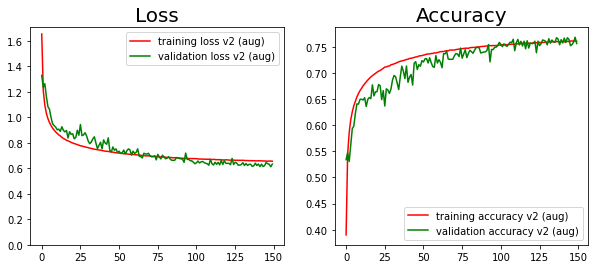

In [ ]:
fig2 = plt.figure(figsize = (10,4))

ax4 = fig2.add_subplot(121)

ax4.plot(aug_hist_cnn_v2.history['loss'], color='red', label='training loss v2 (aug)')
ax4.plot(aug_hist_cnn_v2.history['val_loss'], color='green', label='validation loss v2 (aug)')
ax4.set_title('Loss', fontsize=20)
ax4.set_ylim(bottom=0)
ax4.legend(loc="best")

ax5 = fig2.add_subplot(122)
ax5.plot(aug_hist_cnn_v2.history['accuracy'], color='red', label='training accuracy v2 (aug)')
ax5.plot(aug_hist_cnn_v2.history['val_accuracy'], color='green', label='validation accuracy v2 (aug)')
ax5.set_title('Accuracy', fontsize=20)
ax5.legend(loc="best")

plt.show()